In [1]:
# Quick import cell
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'notebook'])
import scipy as sp
from scipy.fft import fftfreq, fftshift, ifftshift
from scipy.fft import fft, ifft, fft2, ifft2

# Summary of 1D FFT
Suppose you want to do the following transform from $\tilde{f}(k)$ to $f(x)$ with $\tilde{f}(k)$ **real and even**:

$$ f(x) = \int_{-\infty}^{+\infty}\frac{dk}{2\pi}\, e^{-ikx}\tilde{f}(k) $$

1. Evenly sample your $k$ domain $k \in [-K,K]$ so that you have $N$ samples with sample interval $\Delta_k$, and put it in array `k`. Say the sample interval is `delta_k`.
2. Re-order the array `k` using `ifftshift` so that the 0th element corresponds to $k=0$ and the first half of the array corresponds to all $k>0$ while the second half corresponds to all $k<0$.
3. Sample $\tilde{f}(k)$ with the order above and put the outputs in array `f`.
4. To get the fourier transform values `f_FFT`, use `f_FFT = fftshift(delta_k * fft(f) / (2*np.pi))`
5. To get the "frequency bins" `x`, use `x = fftshift(fftfreq(N, delta_k/(2*np.pi)))`
6. The fourier transform pair is `[x, f_FFT]` (or `[x, f_FFT.real]`)
7. For maximum accuracy, make $K$ and $N$ as large as possible.

For real and even functions, the fourier transform will also be real and even, and the forward transform will be the same as the inverse transform (up to factors of $2\pi$). For **general real functions** then, the forward and inverse transforms will differ only by an **overall negative sign** in their imaginary parts.

All of these generalize to 2D FFT.


# Fast Fourier Transforms for Theoretical Physics Applications

Most guides on the Fast Fourier Transforms (FFTs) focus on signal processing and other related applications. In these set of notes, I would like to discuss FFTs from the point of view of theoretical physics, wherein instead of doing fourier transforms between time and frequency, we fourier transform between position and momentum spaces. We will then make a more direct contact with the set of conventions one typically uses in theoretical physics.

## FFT in 1D

### Computing the FT of a Gaussian analytically

In most applications in theoretical physics, the 1D fourier transform is typically defined as

$$f(x) = \int_{-\infty}^{+\infty} \frac{dk}{2\pi} e^{ikx} \tilde{f}(k), \quad \tilde{f}(k) = \int_{-\infty}^{+\infty} dx e^{-ikx} f(x)$$

wherein we denoted $x$ as position and $k$ (really $\hbar k$) as momentum. We see that the above equation is true by noting that

$$ \begin{aligned} 
f(x) &=  \int_{-\infty}^{+\infty} \frac{dk}{2\pi} e^{ikx} \bigg(\int_{-\infty}^{+\infty} dx' e^{-ikx'} f(x')\bigg) \\ 
&=  \int_{-\infty}^{+\infty} dx' f(x') \bigg(\int_{-\infty}^{+\infty} \frac{dk}{2\pi} e^{ik(x-x')} \bigg) \\
&= \int_{-\infty}^{+\infty} dx' f(x') \delta(x-x') = f(x) 
\end{aligned}$$

Let's take a typical example: a gaussian in momentum space, centered at the origin.

$$ \tilde{f}(k) = \sqrt{\frac{a}{2\pi}} \exp\left(-\frac{ak^2}{2} \right) $$

It's fourier transform is given by:

$$ f(x) = \sqrt{\frac{a}{2\pi}} \int_{-\infty}^{+\infty} \frac{dk}{2\pi} \exp\left(ikx - \frac{1}{2} a k^2 \right) $$

which we can calculate by first completing the squares:

$$\begin{aligned} 
f(x) &= \sqrt{\frac{a}{2\pi}} \exp\left(-\frac{x^2}{2a}\right)\int_{-\infty}^{+\infty}\frac{dk}{2\pi} \exp\left[-\frac{a}{2}\left(k - \frac{ix}{a} \right)^2 \right] \\
\end{aligned}$$

and using contour integration: let

$$ f(z) = \exp\left(-\frac{a z^2}{2}\right) $$

be a function of the complex variable $z$. By integrating $f(z)$ over the rectangular contour

![Rectangular contour](contour1.jpg)

and noting that $f(z)$ is analytic over inside the region of integration, we have

$$ \int_C f(z)dz = \int_{-\infty}^{+\infty}dk\, \exp\left(-\frac{a k^2}{2}\right) -  \int_{-\infty}^{+\infty}dk\, \exp\left[-\frac{a}{2}\left(k - \frac{ix}{a} \right)^2\right] = 0$$

(the contributions due to the sides of the rectangle vanish in the limit where the width of the box becomes infinite). Hence, we have

$$ \int_{-\infty}^{+\infty}dk\, \exp\left[-\frac{a}{2}\left(k - \frac{ix}{a} \right)^2\right] = \int_{-\infty}^{+\infty}dk\, \exp\left(-\frac{a k^2}{2}\right) = \sqrt{\frac{2\pi}{a}} $$

and we find that the (inverse) fourier transform of our gaussian is

$$ \tilde{f}(k) = \sqrt{\frac{a}{2\pi}} \exp\left(-\frac{ak^2}{2} \right) \quad \xrightarrow{\text{IFT}} \quad  f(x) = \frac{1}{2\pi}\exp\left(-\frac{x^2}{2a}\right) $$

We try to plot these below

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'notebook'])

In [144]:
def gauss_mom(k, a):
    return np.sqrt(a/(2*np.pi))*np.exp(-(a*k**2)/2)

def gauss_pos(x, a):
    return np.exp((-x**2)/(2*a))/(2*np.pi)

In [146]:
Nk, Nx, a = 100, 100, 1
k = np.linspace(-10, 10, Nk)
x = np.linspace(-10, 10, Nx)
fk = gauss_mom(k, a)
fx = gauss_pos(x, a)

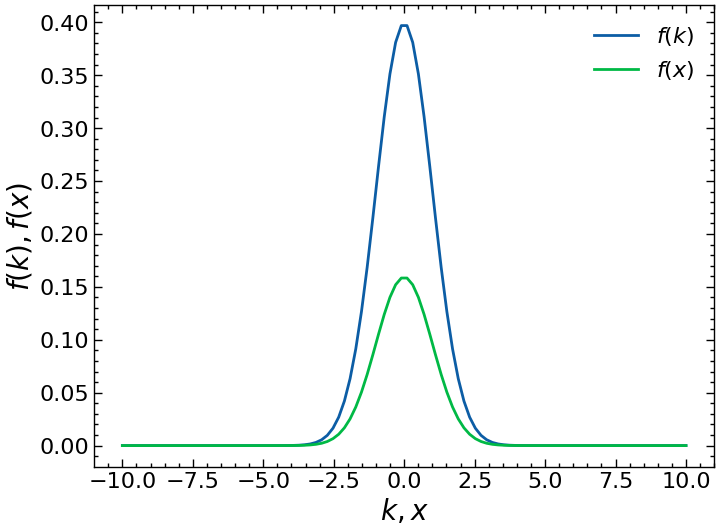

In [147]:
plt.plot(k, fk, label='$f(k)$')
plt.plot(x, fx, label='$f(x)$')
plt.legend(loc='best')
plt.ylabel('$f(k), f(x)$', fontsize=20)
plt.xlabel('$k, x$', fontsize=20)
plt.show()

### Computing the FT of a Gaussian Numerically

Virtually all implementations of the FFT operate under the following conventions: given a time variable $t$ and a frequency variable $f$, the fourier transform pair is given by

$$ H(f) = \int_{-\infty}^{+\infty} h(t) e^{-i 2\pi f t}\, dt, \quad h(t) = \int_{-\infty}^{+\infty} H(f)e^{+i 2\pi f t}\, df $$

where the left equation denotes the so-called "forward fourier transform" and the right equation denotes the so-called "inverse fourier transform". We note that these are related to the physics definitions we put in the beginning by the replacement $f = \omega/(2\pi)$ in the second integral:

$$ h(t) = \int_{-\infty}^{+\infty} \tilde{H}(\omega) e^{+i\omega t}\, \frac{d\omega}{2\pi}, \quad \tilde{H}(\omega) = H\left(\frac{\omega}{2\pi}\right) $$

and of course, $t \leftrightarrow x$, $\omega \leftrightarrow k$.

The variable $f$ is usually called the "frequency" in non-theoretical physics applications, while the variable $\omega$ is technically called the "frequency" in theoretical physics applications, although it is technically the angular frequency. Hence, when one wants to numerically calculate the "physics fourier transform" of a function $\tilde{H}(\omega)$ (or $\tilde{H}(k)$), one has to convert it first to the corresponding function $H(f)$, i.e.,

$$ (\omega_n, \tilde{H}(\omega_n)) \equiv (\omega_n, \tilde{H}_n) \quad \Rightarrow \quad (2\pi\omega_n, \tilde{H}_n) $$

So, how does the FFT work? Instead of having a continuous function $h(t)$, we have a discrete set of data points $(t_j, h_j)$ where $t_j = j\Delta t$, $h_j = h(t_j)$, and $j$ is some integer. If you have $N$ sample points $t_j$, then the fourer tranform will also have $N$ samples. The discrete fourier transform is given by

$$ H(f_n) = \sum_{j=0}^{N-1} h_j e^{-i 2\pi f_n t_j}, \quad n = 0, 1, \ldots, N-1 $$

Comparing this to the continuous case, we see that the sum is **missing a factor of** $\Delta t$. We must keep this fact in mind when interpreting the FFT. Using $t_j = j\Delta t$ and $f_n = \frac{n}{N\Delta t}$, we can write this as

$$ H(f_n) = \sum_{j=0}^{N-1} h_j e^{-i 2\pi nj/N} $$

The inverse discrete fourier transform is then given by

$$ h(t_j) = \frac{1}{N}\sum_{n=0}^{N-1} H_j e^{+i 2\pi nj/N} $$

The numerical calculation of these sums using FFT are not done in a straightforward way. Instead, FFT uses a very fast algorithm by Cooley and Tukey that we will discuss here. It suffices to know what conventions FFT algorithms use.

The fourier and inverse fourier transforms can be done in python via the `scipy.fft` library using the codes `fft(array)` and `ifft(array)` respectively. For example

In [15]:
import scipy as sp
from scipy.fft import fftfreq, fftshift
from scipy.fft import fft, ifft

x = np.array([1.0, 2.0, 1.0, -1.0, 1.5])
y = fft(x)
y

array([ 4.5       -0.j        ,  2.08155948-1.65109876j,
       -1.83155948+1.60822041j, -1.83155948-1.60822041j,
        2.08155948+1.65109876j])

In [8]:
yinv = ifft(y)
yinv

array([ 1. +0.j,  2. +0.j,  1. +0.j, -1. +0.j,  1.5+0.j])

Note that the `fft` function arranges the frequencies with the first half being the positive frequencies while the second half being arranged in order of decreasingly negative frequencies. For example, if $N$ is even, then the corresponding frequencies are ordered as $[0, 1, \ldots, N/2 - 1, -N/2, \ldots, -1]$. On the other hand, if $N$ is odd, then $[0, 1, \ldots, (N-1)/2, -(N-1)/2, \ldots, -1]$. We can use the `fftshift` function to sort this in canonical order.

How do we modify the FFT implementations to suit our needs? Say we want to use the `ifft` command to a set of data points sampled from our Gaussian example

$$ \tilde{f}(k) = \sqrt{\frac{a}{2\pi}} \exp\left(-\frac{ak^2}{2} \right) $$

That is, we want our inverse fourier transform to approximate very well the function

$$ f(x) = \frac{1}{2\pi}\exp\left(-\frac{x^2}{2a}\right) $$

If we try to use `ifft` unmodified, we find that we won't get the right answer:

In [148]:
def gauss_mom(k, a):
    return np.sqrt(a/(2*np.pi))*np.exp(-(a*k**2)/2)

def gauss_pos(x, a):
    return (1/(2*np.pi))*np.exp(-x**2/(2*a))

Nk, Nx, a = 100, 100, 1
k = np.linspace(-10, 10, Nk)
x = np.linspace(-10, 10, Nx)
fk = gauss_mom(k, a)
fx = gauss_pos(x, a)

xnew = (fftfreq(len(k), np.diff(k)[0]))
fk_FFT = ifft(fk)

In [149]:
xnew = (fftfreq(len(k), np.diff(k)[0]))
fftshift(xnew)

array([-2.475 , -2.4255, -2.376 , -2.3265, -2.277 , -2.2275, -2.178 ,
       -2.1285, -2.079 , -2.0295, -1.98  , -1.9305, -1.881 , -1.8315,
       -1.782 , -1.7325, -1.683 , -1.6335, -1.584 , -1.5345, -1.485 ,
       -1.4355, -1.386 , -1.3365, -1.287 , -1.2375, -1.188 , -1.1385,
       -1.089 , -1.0395, -0.99  , -0.9405, -0.891 , -0.8415, -0.792 ,
       -0.7425, -0.693 , -0.6435, -0.594 , -0.5445, -0.495 , -0.4455,
       -0.396 , -0.3465, -0.297 , -0.2475, -0.198 , -0.1485, -0.099 ,
       -0.0495,  0.    ,  0.0495,  0.099 ,  0.1485,  0.198 ,  0.2475,
        0.297 ,  0.3465,  0.396 ,  0.4455,  0.495 ,  0.5445,  0.594 ,
        0.6435,  0.693 ,  0.7425,  0.792 ,  0.8415,  0.891 ,  0.9405,
        0.99  ,  1.0395,  1.089 ,  1.1385,  1.188 ,  1.2375,  1.287 ,
        1.3365,  1.386 ,  1.4355,  1.485 ,  1.5345,  1.584 ,  1.6335,
        1.683 ,  1.7325,  1.782 ,  1.8315,  1.881 ,  1.9305,  1.98  ,
        2.0295,  2.079 ,  2.1285,  2.178 ,  2.2275,  2.277 ,  2.3265,
        2.376 ,  2.4

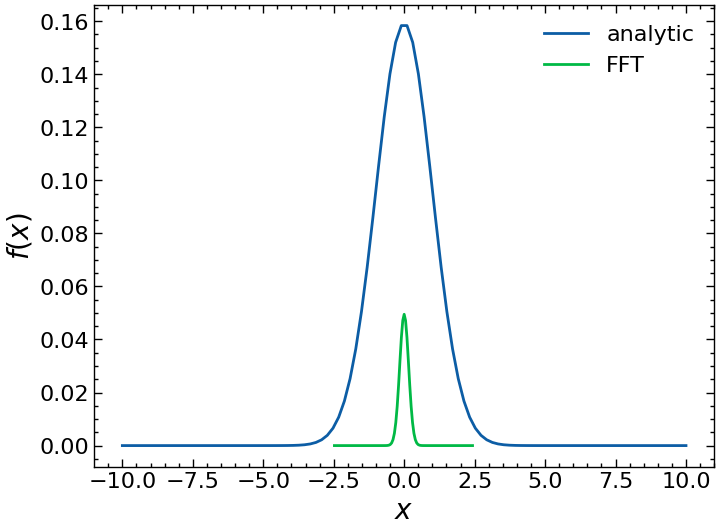

In [150]:
plt.plot(x, fx, label='analytic')
plt.plot(fftshift(xnew), np.abs(fftshift(fk_FFT)), label='FFT')
#plt.plot(xnew, np.abs(fk_FFT), label='FFT')
plt.legend(loc='best')
plt.ylabel('$f(x)$', fontsize=20)
plt.xlabel('$x$', fontsize=20)
plt.show()

We see that besides the vast difference in magnitude of $f(x)$, the sampled $x$ values obtained from `fftfreq` are also wrong. That is because `fftfreq` gets the "frequency" samples, not the "time" samples. In our case, the "frequency space" is given by $k$ while the "time space" is given by $x$. We try another approach. We instead use the `fft` function. We can do this because for **real even functions** $h(t)$, we have

$$ \int_{-\infty}^{+\infty} h(t) e^{-i2\pi f t}\,dt = \int_{-\infty}^{+\infty} h(t) e^{+i2\pi f t}\,dt $$

This means that for the case of the gaussian in $k$ space, we can treat $k$ as our "time" variable, and $x$ as our "frequency" variable, i.e., we will try to verify numerically

$$ \tilde{f}(k) = \sqrt{\frac{a}{2\pi}} \exp\left(-\frac{ak^2}{2} \right) \quad \xrightarrow{\text{FT}} \quad f(x) = \frac{1}{2\pi}\exp\left(-\frac{x^2}{2a}\right) $$

Now, since the transform that we want is related to the one that FFT uses via a change of integration variable

$$ \frac{1}{2\pi}\int_{-\infty}^{+\infty}\,d\tau \tilde{h}(\tau)e^{-ift} \quad \xrightarrow{\tau = 2\pi t} \quad \int_{-\infty}^{+\infty} h(t)e^{-i2\pi f t} $$

$\Delta \tau$ in $\tau$ space becomes $\Delta t = \Delta \tau/2\pi$ in $t$ space. Hence, we must set the sampling rate in `fftfreq` as $\Delta \tau/2\pi$. Also, recall the missing $\Delta t$ factor in the definition of the DFT:

$$ H(f) = \int_{-\infty}^{+\infty} h(t) e^{-i 2\pi f t}\, dt \quad \xrightarrow{DFT} \quad H(f_n) = \sum_{j=0}^{N-1} h_j e^{-i 2\pi f_n t_j} $$

Hence, to approximate the analytic result, we must multiply $\Delta t = \Delta \tau/2\pi$ to the output given by the FFT.

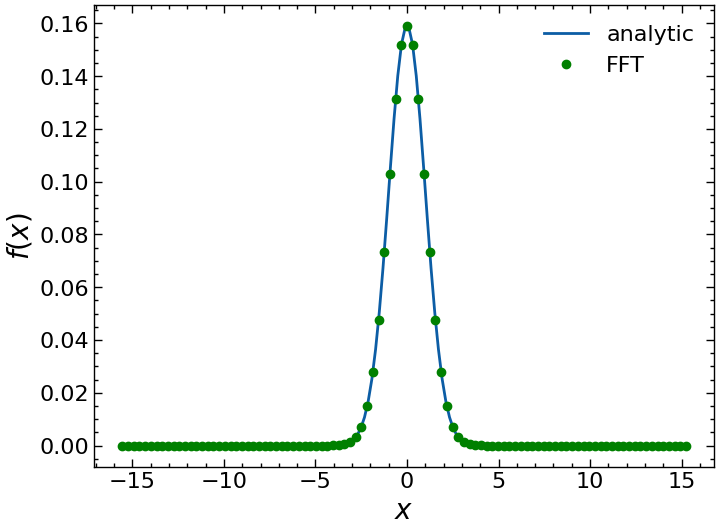

In [157]:
def gauss_mom(k, a):
    return np.sqrt(a/(2*np.pi))*np.exp(-(a*k**2)/2)

def gauss_pos(x, a):
    return (1/(2*np.pi))*np.exp(-x**2/(2*a))

Nx, a = 100, 1
Nk = 100
k = np.linspace(-10, 10, Nk)
x = np.linspace(-10, 10, Nx)
fk = gauss_mom(k, a)
fx = gauss_pos(x, a)

xnew = (fftfreq(len(k), np.diff(k)[0]/(2*np.pi))) #We set \Delta t as \Delta \tau/2\pi
fk_FFT = (np.diff(k)[0]/(2*np.pi))*fft(fk) #We multiply \Delta t to the output

plt.plot(x, fx, label='analytic')
plt.plot(fftshift(xnew), np.abs(fftshift(fk_FFT)), 'go', label='FFT')
plt.legend(loc='best')
plt.ylabel('$f(x)$', fontsize=20)
plt.xlabel('$x$', fontsize=20)
plt.show()

We see that we matched the analytic result quite well. Let's try to see what happens when we
- changing the sampling rate
- changing the "integration window", i.e., the distance $k_\text{max} - k_\text{min}$ of the domain of $\tilde{f}(k)$

#### Changing the sampling rate
Let's try the gaussian for $a=10$. We sample $\tilde{f}(k)$ for $k \in [-10,10]$ but with different number of samples $N_k$.

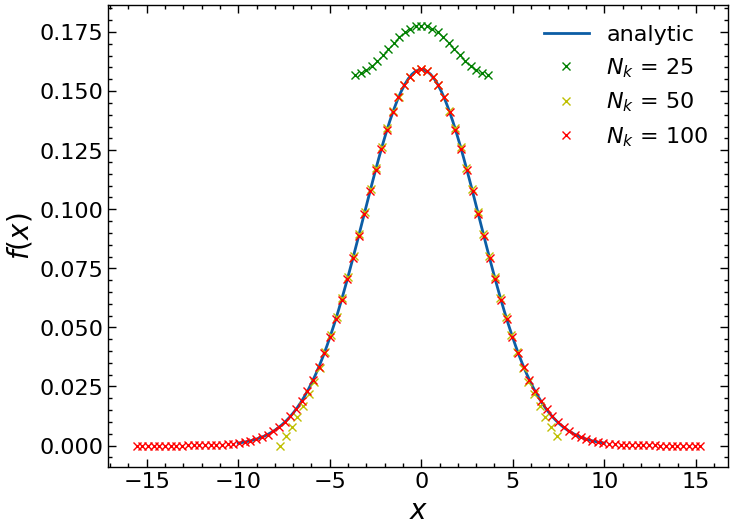

In [180]:
def gauss_mom(k, a):
    return np.sqrt(a/(2*np.pi))*np.exp(-(a*k**2)/2)

def gauss_pos(x, a):
    return (1/(2*np.pi))*np.exp(-x**2/(2*a))

Nx, a = 100, 10
Nk = [25, 50, 100]
k = [np.linspace(-10, 10, i) for i in Nk]
x = np.linspace(-10, 10, Nx)
fk = [gauss_mom(k[i], a) for i in range(len(Nk))]
fx = gauss_pos(x, a)

xnew = [(fftfreq(len(k[i]), np.diff(k[i])[0]/(2*np.pi))) for i in range(len(Nk))] #We set \Delta t as \Delta \tau/2\pi
fk_FFT = [(np.diff(k[i])[0]/(2*np.pi))*fft(fk[i]) for i in range(len(Nk))] #We multiplied \Delta t to FFT

markers = ['gx', 'yx', 'rx']
plt.plot(x, fx, label='analytic')
for i in range(len(Nk)):
    plt.plot(fftshift(xnew[i]), np.abs(fftshift(fk_FFT[i])), markers[i], label='$N_k$ = {}'.format(Nk[i]))
plt.legend(loc='best')
plt.ylabel('$f(x)$', fontsize=20)
plt.xlabel('$x$', fontsize=20)
plt.show()

We see that for the same domain size $k \in [-10,10]$, the FFT gets worse as you decrease the number of samples. It becomes atrocious for $N_k = 25$. This is known as **aliasing**. The theory behind aliasing will be discussed at the end of this notebook. The important thing to know is that we generally want to **sample our data at a high rate** to avoid aliasing effects.

#### Changing the domain

Next we try the gaussian, but with $a=0.5$, for the same $N_k = 100$, but we vary the sample domain $N_k \in [-|k_\text{max}|,+|k_\text{max}|]$. Let's see how our gaussian looks like before fourier transforming:

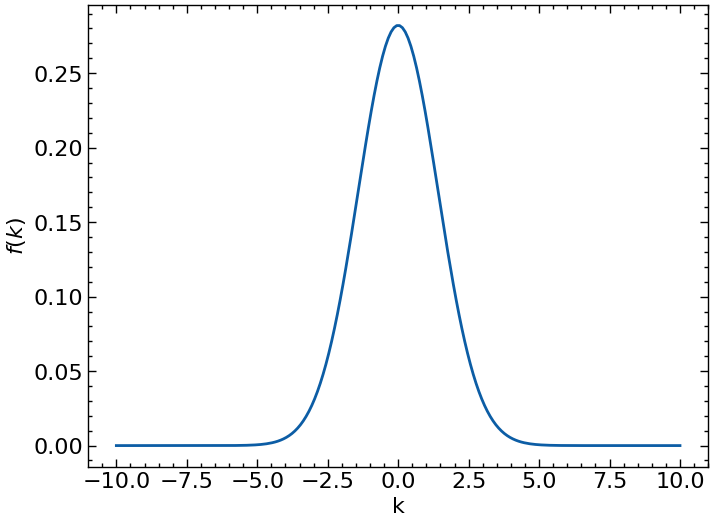

In [197]:
def gauss_mom(k, a):
    return np.sqrt(a/(2*np.pi))*np.exp(-(a*k**2)/2)
Nk = 200
a=0.5
k = np.linspace(-10,10,Nk)
fk = gauss_mom(k,a)
plt.plot(k,fk)
plt.ylabel('$f(k)$')
plt.xlabel('k')
plt.show()

Let's try to cut our domain at $k_\text{max}$ values $(1,3,7)$

In [216]:
def gauss_mom(k, a):
    return np.sqrt(a/(2*np.pi))*np.exp(-(a*k**2)/2)

def gauss_pos(x, a):
    return (1/(2*np.pi))*np.exp(-x**2/(2*a))

Nx, a = 200, 0.5
Nk = 100
kmax = [1,3,7]
nplots = len(kmax)
k = [np.linspace(-i, i, Nk) for i in kmax]
x = np.linspace(-20, 20, Nx)
fk = [gauss_mom(k[i], a) for i in range(nplots)]
fx = gauss_pos(x, a)

xnew = [(fftfreq(len(k[i]), np.diff(k[i])[0]/(2*np.pi))) for i in range(nplots)] #We set \Delta t as \Delta \tau/2\pi
fk_FFT = [(np.diff(k[i])[0]/(2*np.pi))*fft(fk[i]) for i in range(nplots)] #We multiplied \Delta t to FFT

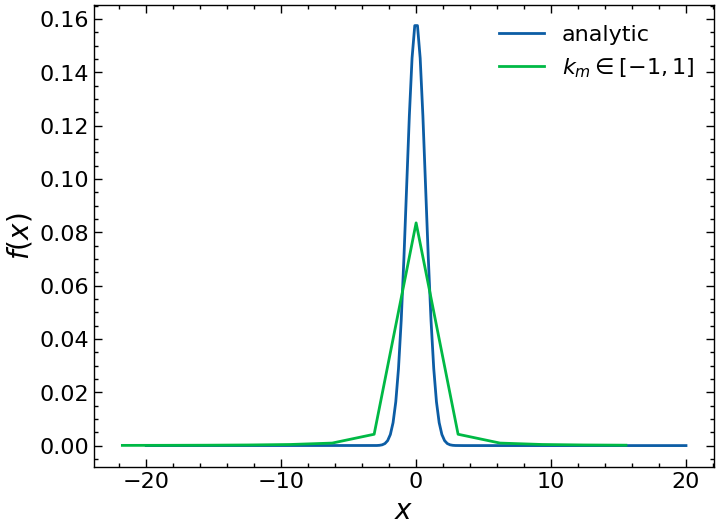

In [210]:
plt.plot(x, fx, label='analytic')
plt.plot(fftshift(xnew[0])[7*Nk//16:9*Nk//16], np.abs(fftshift(fk_FFT[0]))[7*Nk//16:9*Nk//16], label='$k_m \in [-1,1]$')
plt.legend(loc='best')
plt.ylabel('$f(x)$', fontsize=20)
plt.xlabel('$x$', fontsize=20)
plt.show()

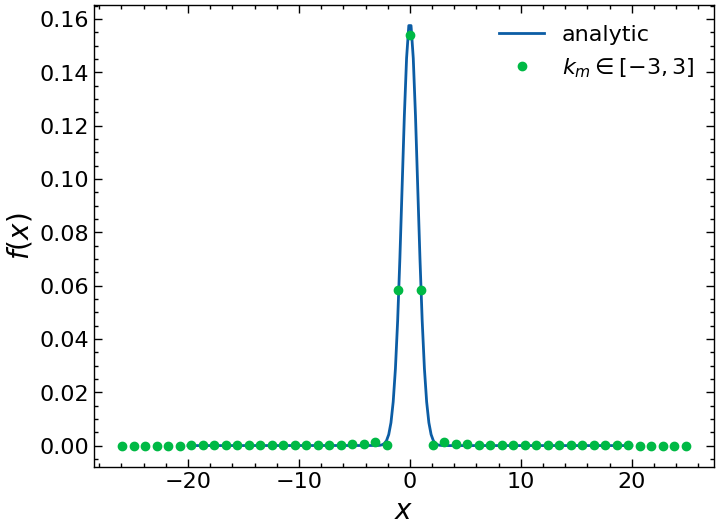

In [215]:
plt.plot(x, fx, label='analytic')
plt.plot(fftshift(xnew[1])[Nk//4:3*Nk//4], np.abs(fftshift(fk_FFT[1]))[Nk//4:3*Nk//4], 'o' , label='$k_m \in [-3,3]$')
plt.legend(loc='best')
plt.ylabel('$f(x)$', fontsize=20)
plt.xlabel('$x$', fontsize=20)
plt.show()

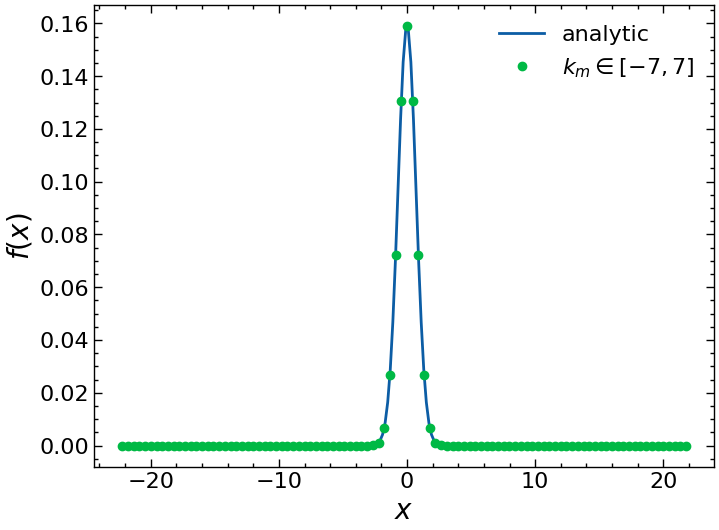

In [214]:
plt.plot(x, fx, label='analytic')
plt.plot(fftshift(xnew[2]), np.abs(fftshift(fk_FFT[2])), 'o' ,label='$k_m \in [-7,7]$')
plt.legend(loc='best')
plt.ylabel('$f(x)$', fontsize=20)
plt.xlabel('$x$', fontsize=20)
plt.show()

We see that the FFT gets worse as we reduce the FFT domain. The errors are a mixture of **Rippling** and **Leakage**. The theory behind these things will be discussed at the end of this notebook. The important thing to know is that we generally want to **extend our integration domain as far as possible**.

## The phase problem
One thing you may have noticed is that everytime we implemented the FFT above, we plotted the absolute value of the FFT, not the FFT itself. Let's take our first example where we set $a = 1$ and $N_k  = 100$, but instead of plotting the absolute value, we plot the real and imaginary part of the FFT.

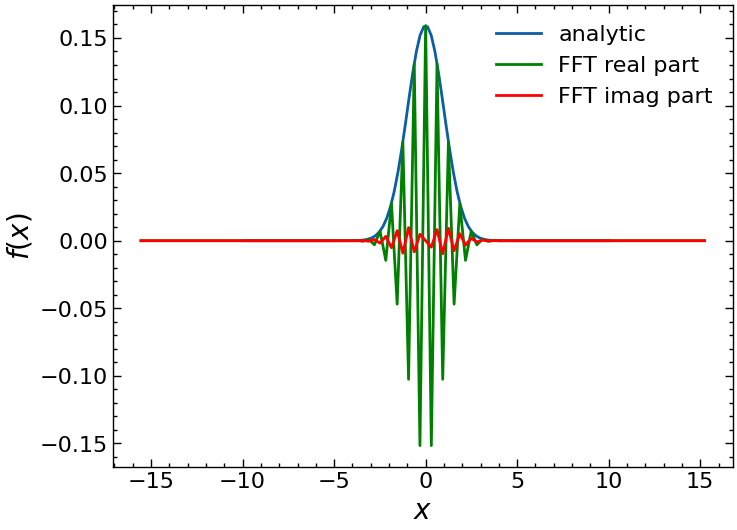

In [7]:
def gauss_mom(k, a):
    return np.sqrt(a/(2*np.pi))*np.exp(-(a*k**2)/2)

def gauss_pos(x, a):
    return (1/(2*np.pi))*np.exp(-x**2/(2*a))

Nx, a = 100, 1
Nk = 100
k = np.linspace(-10, 10, Nk)
x = np.linspace(-10, 10, Nx)
fk = gauss_mom(k, a)
fx = gauss_pos(x, a)

xnew = (fftfreq(len(k), np.diff(k)[0]/(2*np.pi))) #We set \Delta t as \Delta \tau/2\pi
fk_FFT = (np.diff(k)[0]/(2*np.pi))*fft(fk) #We multiply \Delta t to the output

plt.plot(x, fx, label='analytic')
plt.plot(fftshift(xnew), np.real(fftshift(fk_FFT)), 'g-', label='FFT real part')
plt.plot(fftshift(xnew), np.imag(fftshift(fk_FFT)), 'r-', label='FFT imag part')
plt.legend(loc='best')
plt.ylabel('$f(x)$', fontsize=20)
plt.xlabel('$x$', fontsize=20)
plt.show()

We see that every other FFT point is way off. Why is this? This has something to do with Scipy's assumed data ordering of the "time" and "frequency" domains (see Bernard's answer in this [Stackexchange post](https://stackoverflow.com/questions/5398304/fourier-transform-of-a-gaussian-is-not-a-gaussian-but-thats-wrong-python).) The issue is not in the definition of the discrete fourier transform, but in the implementation of the FFT algorithm itself. Without going into the weeds, we must order our data such that the first value in the array corresponds to $t = 0$.

In [10]:
def gauss_mom(k, a):
    return np.sqrt(a/(2*np.pi))*np.exp(-(a*k**2)/2)

def gauss_pos(x, a):
    return (1/(2*np.pi))*np.exp(-x**2/(2*a))

Nx, a = 100, 1
Nk = 100

Instead of ordering our gaussian like this:

In [14]:
k = np.linspace(-10,10,Nk)
fk = gauss_mom(k, a)
k

array([-10.        ,  -9.7979798 ,  -9.5959596 ,  -9.39393939,
        -9.19191919,  -8.98989899,  -8.78787879,  -8.58585859,
        -8.38383838,  -8.18181818,  -7.97979798,  -7.77777778,
        -7.57575758,  -7.37373737,  -7.17171717,  -6.96969697,
        -6.76767677,  -6.56565657,  -6.36363636,  -6.16161616,
        -5.95959596,  -5.75757576,  -5.55555556,  -5.35353535,
        -5.15151515,  -4.94949495,  -4.74747475,  -4.54545455,
        -4.34343434,  -4.14141414,  -3.93939394,  -3.73737374,
        -3.53535354,  -3.33333333,  -3.13131313,  -2.92929293,
        -2.72727273,  -2.52525253,  -2.32323232,  -2.12121212,
        -1.91919192,  -1.71717172,  -1.51515152,  -1.31313131,
        -1.11111111,  -0.90909091,  -0.70707071,  -0.50505051,
        -0.3030303 ,  -0.1010101 ,   0.1010101 ,   0.3030303 ,
         0.50505051,   0.70707071,   0.90909091,   1.11111111,
         1.31313131,   1.51515152,   1.71717172,   1.91919192,
         2.12121212,   2.32323232,   2.52525253,   2.72

In [15]:
fk

array([7.69459863e-23, 5.68442201e-22, 4.03145816e-21, 2.74481769e-20,
       1.79407401e-19, 1.12575195e-18, 6.78141882e-18, 3.92169602e-17,
       2.17722239e-16, 1.16039850e-15, 5.93727315e-15, 2.91636853e-14,
       1.37522348e-13, 6.22557774e-13, 2.70558725e-12, 1.12880502e-11,
       4.52118024e-11, 1.73844203e-10, 6.41717835e-10, 2.27406833e-09,
       7.73639102e-09, 2.52667171e-08, 7.92199799e-08, 2.38449349e-07,
       6.89021948e-07, 1.91137312e-06, 5.09018302e-06, 1.30135811e-05,
       3.19400618e-05, 7.52575687e-05, 1.70231576e-04, 3.69662637e-04,
       7.70631042e-04, 1.54227900e-03, 2.96315857e-03, 5.46540492e-03,
       9.67754721e-03, 1.64506763e-02, 2.68458845e-02, 4.20578610e-02,
       6.32546052e-02, 9.13298239e-02, 1.26592680e-01, 1.68453513e-01,
       2.15192461e-01, 2.63906165e-01, 3.10704486e-01, 3.51172916e-01,
       3.81039507e-01, 3.96912251e-01, 3.96912251e-01, 3.81039507e-01,
       3.51172916e-01, 3.10704486e-01, 2.63906165e-01, 2.15192461e-01,
      

We must instead order it like this:

In [16]:
k = ifftshift(np.linspace(-10,10,Nk))
fk = gauss_mom(k, a)
k

array([  0.1010101 ,   0.3030303 ,   0.50505051,   0.70707071,
         0.90909091,   1.11111111,   1.31313131,   1.51515152,
         1.71717172,   1.91919192,   2.12121212,   2.32323232,
         2.52525253,   2.72727273,   2.92929293,   3.13131313,
         3.33333333,   3.53535354,   3.73737374,   3.93939394,
         4.14141414,   4.34343434,   4.54545455,   4.74747475,
         4.94949495,   5.15151515,   5.35353535,   5.55555556,
         5.75757576,   5.95959596,   6.16161616,   6.36363636,
         6.56565657,   6.76767677,   6.96969697,   7.17171717,
         7.37373737,   7.57575758,   7.77777778,   7.97979798,
         8.18181818,   8.38383838,   8.58585859,   8.78787879,
         8.98989899,   9.19191919,   9.39393939,   9.5959596 ,
         9.7979798 ,  10.        , -10.        ,  -9.7979798 ,
        -9.5959596 ,  -9.39393939,  -9.19191919,  -8.98989899,
        -8.78787879,  -8.58585859,  -8.38383838,  -8.18181818,
        -7.97979798,  -7.77777778,  -7.57575758,  -7.37

In [17]:
fk

array([3.96912251e-01, 3.81039507e-01, 3.51172916e-01, 3.10704486e-01,
       2.63906165e-01, 2.15192461e-01, 1.68453513e-01, 1.26592680e-01,
       9.13298239e-02, 6.32546052e-02, 4.20578610e-02, 2.68458845e-02,
       1.64506763e-02, 9.67754721e-03, 5.46540492e-03, 2.96315857e-03,
       1.54227900e-03, 7.70631042e-04, 3.69662637e-04, 1.70231576e-04,
       7.52575687e-05, 3.19400618e-05, 1.30135811e-05, 5.09018302e-06,
       1.91137312e-06, 6.89021948e-07, 2.38449349e-07, 7.92199799e-08,
       2.52667171e-08, 7.73639102e-09, 2.27406833e-09, 6.41717835e-10,
       1.73844203e-10, 4.52118024e-11, 1.12880502e-11, 2.70558725e-12,
       6.22557774e-13, 1.37522348e-13, 2.91636853e-14, 5.93727315e-15,
       1.16039850e-15, 2.17722239e-16, 3.92169602e-17, 6.78141882e-18,
       1.12575195e-18, 1.79407401e-19, 2.74481769e-20, 4.03145816e-21,
       5.68442201e-22, 7.69459863e-23, 7.69459863e-23, 5.68442201e-22,
       4.03145816e-21, 2.74481769e-20, 1.79407401e-19, 1.12575195e-18,
      

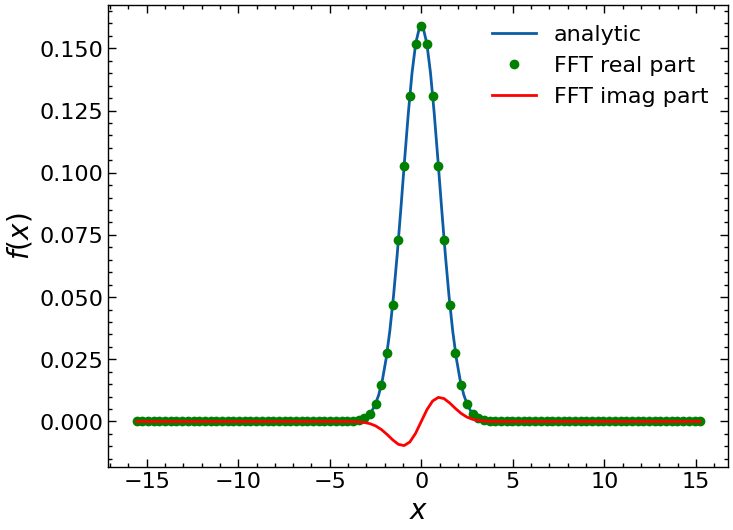

In [9]:
k = ifftshift(np.linspace(-10, 10, Nk)) # The first point of the array should correspond to the t=0 point.
x = np.linspace(-10, 10, Nx)
fk = gauss_mom(k, a)
fx = gauss_pos(x, a)

xnew = (fftfreq(len(k), np.diff(k)[0]/(2*np.pi))) #We set \Delta t as \Delta \tau/2\pi
fk_FFT = (np.diff(k)[0]/(2*np.pi))*fft(fk) #We multiply \Delta t to the output

plt.plot(x, fx, label='analytic')
plt.plot(fftshift(xnew), np.real(fftshift(fk_FFT)), 'go', label='FFT real part')
plt.plot(fftshift(xnew), np.imag(fftshift(fk_FFT)), 'r-', label='FFT imag part')
plt.legend(loc='best')
plt.ylabel('$f(x)$', fontsize=20)
plt.xlabel('$x$', fontsize=20)
plt.show()

Much better! At least the real part of the FFT is exact. Notice that the imaginary part is nonzero since `k[0] = 0.10101010...` is not 0. If we instead have $N_k$ odd, then we will exactly have vanishing imaginary part.

Whether $N$ was even or odd, it didn't make a difference in the real part of the fourier transform.

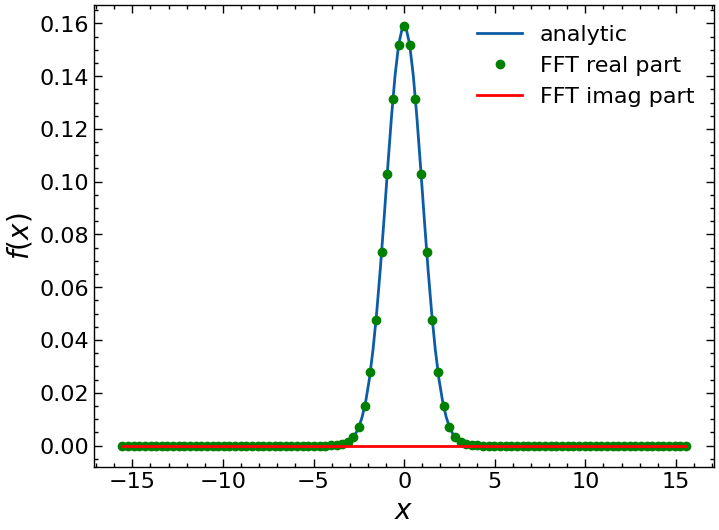

In [18]:
Nx, a = 100, 1
Nk = 101
k = ifftshift(np.linspace(-10, 10, Nk)) # The first point of the array should correspond to the t=0 point.
x = np.linspace(-10, 10, Nx)
fk = gauss_mom(k, a)
fx = gauss_pos(x, a)

xnew = (fftfreq(len(k), np.diff(k)[0]/(2*np.pi))) #We set \Delta t as \Delta \tau/2\pi
fk_FFT = (np.diff(k)[0]/(2*np.pi))*fft(fk) #We multiply \Delta t to the output

plt.plot(x, fx, label='analytic')
plt.plot(fftshift(xnew), np.real(fftshift(fk_FFT)), 'go', label='FFT real part')
plt.plot(fftshift(xnew), np.imag(fftshift(fk_FFT)), 'r-', label='FFT imag part')
plt.legend(loc='best')
plt.ylabel('$f(x)$', fontsize=20)
plt.xlabel('$x$', fontsize=20)
plt.show()

## FFT in 2D
In 2D, a lot of the things generalize straightforwardly. Instead of using `fft`, we use `fft2`. Instead of multiplying $\Delta k / 2\pi$ we multiply $\Delta k_x \Delta k_y / (2\pi)^2$. Here we try to get the fourier transform of the radially symmetric gaussian

$$ \tilde{f}(\mathbf{k}) = \frac{a}{2\pi} \exp\left[-\frac{a\left(k_x^2 + k_y^2\right)}{2}\right] \quad \xrightarrow{FT} \quad f(\mathbf{x}) = \frac{1}{(2\pi)^2}\exp\left[-\frac{\left(x^2 + y^2\right)}{2a}\right] $$


In [19]:
def gauss2_mom(kx,ky,a):
    return (a/(2*np.pi))*np.exp(-a*(kx**2 + ky**2)/2)

def gauss2_pos(x,y,a):
    return np.exp(-(x**2 + y**2)/(2*a))/((2*np.pi)**2)

Nk = 101
Nx = 101
a = 10
kx = np.linspace(-10,10,Nk)
ky = np.linspace(-10,10,Nk)
x = np.linspace(-10,10,Nx)
y = np.linspace(-10,10,Nx)

kxv, kyv = np.meshgrid(ifftshift(kx), ifftshift(ky))
xv, yv = np.meshgrid(x,y)

fk = gauss2_mom(kxv, kyv, a)
fx = gauss2_pos(xv, yv, a)

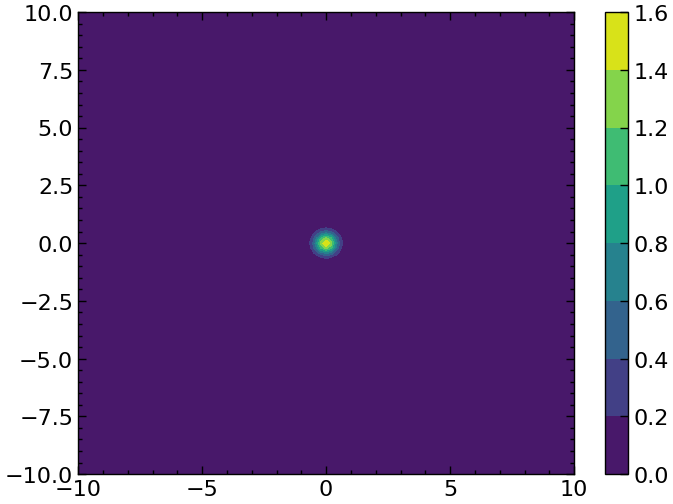

In [21]:
plot = plt.contourf(fftshift(kxv), fftshift(kyv), fftshift(fk))
plt.colorbar(plot)
plt.show()

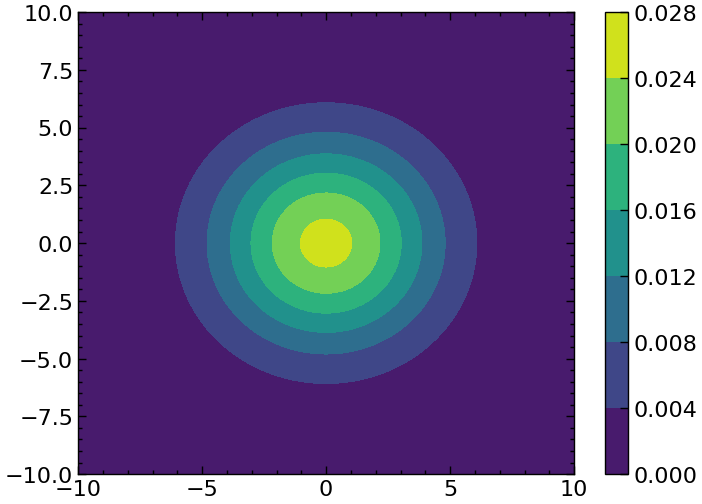

In [22]:
plot = plt.contourf(xv, yv, fx)
plt.colorbar(plot)
plt.show()

In [23]:
fk_FFT = fftshift(np.diff(kx)[0]*np.diff(ky)[0]*fft2(fk)/((2*np.pi)**2))
xnew = fftshift(fftfreq(len(kx), np.diff(kx)[0] / (2*np.pi)))
ynew = fftshift(fftfreq(len(ky), np.diff(ky)[0] / (2*np.pi)))

xvnew, yvnew = np.meshgrid(xnew, ynew)

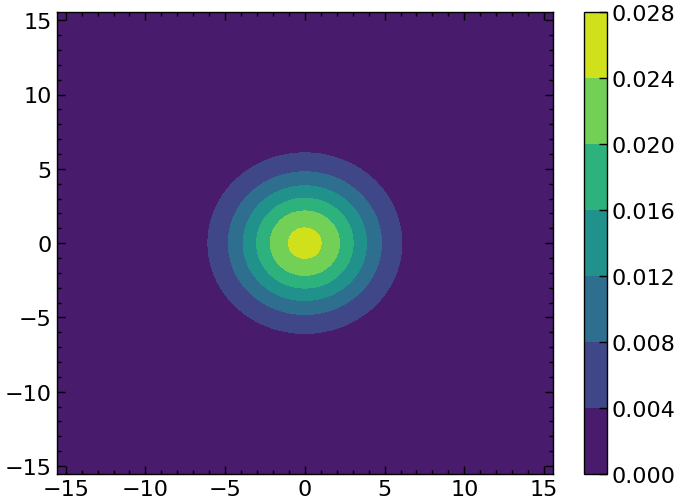

In [24]:
plot = plt.contourf(xnew, ynew, np.real(fk_FFT))
plt.colorbar(plot)
plt.show()

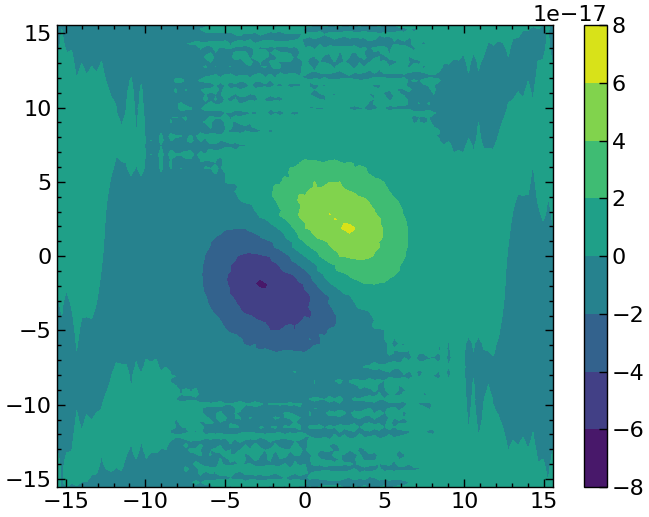

In [25]:
plot = plt.contourf(xnew, ynew, np.imag(fk_FFT))
plt.colorbar(plot)
plt.show()

# Theoretical development of the Discrete Fourier Transform: Aliasing, Rippling, and Leakage

# Mistakes

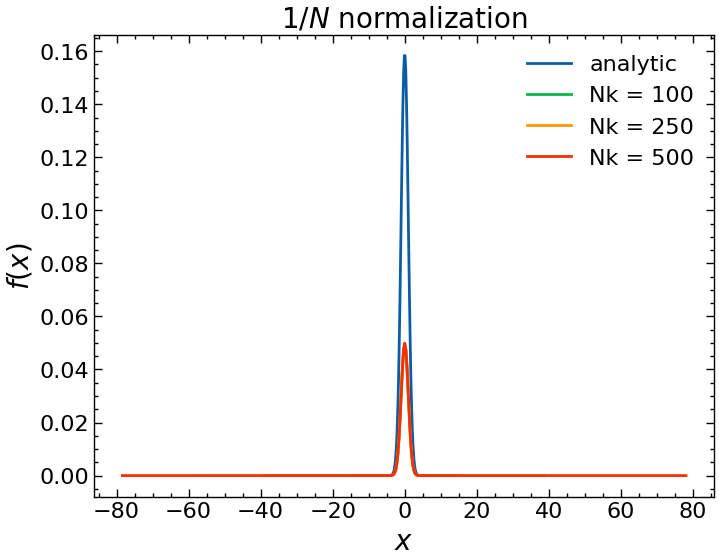

In [177]:
def gauss_mom(k, a):
    return np.sqrt(a/(2*np.pi))*np.exp(-(a*k**2)/2)

def gauss_pos(x, a):
    return (1/(2*np.pi))*np.exp(-x**2/(2*a))

Nx, a = 100, 1
Nk = [100, 250, 500]
k = [np.linspace(-10, 10, i) for i in Nk]
x = np.linspace(-10, 10, Nx)
fk = [gauss_mom(k[i], a) for i in range(len(Nk))]
fx = gauss_pos(x, a)

xnew = [(fftfreq(len(k[i]), np.diff(k[i])[0]/(2*np.pi))) for i in range(len(Nk))] #We set \Delta t as \Delta \tau/2\pi
fk_FFT = [(1/Nk[i])*fft(fk[i]) for i in range(len(Nk))] #Normalized over N

plt.plot(x, fx, label='analytic')
for i in range(len(Nk)):
    plt.plot(fftshift(xnew[i]), np.abs(fftshift(fk_FFT[i])), label='Nk = {}'.format(Nk[i]))
plt.legend(loc='best')
plt.ylabel('$f(x)$', fontsize=20)
plt.xlabel('$x$', fontsize=20)
plt.title('$1/N$ normalization', fontsize=20)
plt.show()

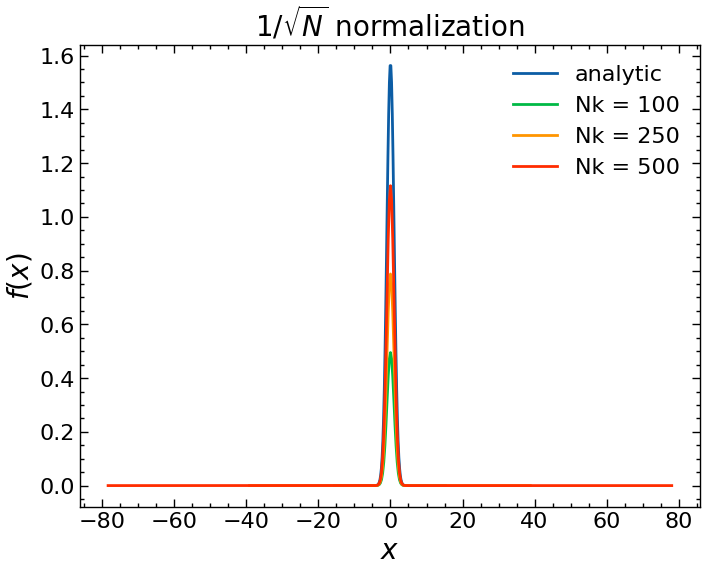

In [178]:
def gauss_mom(k, a):
    return np.sqrt(a/(2*np.pi))*np.exp(-(a*k**2)/2)

def gauss_pos(x, a):
    return (1/2*np.pi)*np.exp(-x**2/(2*a))

Nx, a = 100, 1
Nk = [100, 250, 500]
k = [np.linspace(-10, 10, i) for i in Nk]
x = np.linspace(-10, 10, Nx)
fk = [gauss_mom(k[i], a) for i in range(len(Nk))]
fx = gauss_pos(x, a)

xnew = [(fftfreq(len(k[i]), np.diff(k[i])[0]/(2*np.pi))) for i in range(len(Nk))] #We set \Delta t as \Delta \tau/2\pi
fk_FFT = [(1/np.sqrt(Nk[i]))*fft(fk[i]) for i in range(len(Nk))] #Normalized over sqrt(N)

plt.plot(x, fx, label='analytic')
for i in range(len(Nk)):
    plt.plot(fftshift(xnew[i]), np.abs(fftshift(fk_FFT[i])), label='Nk = {}'.format(Nk[i]))
plt.legend(loc='best')
plt.ylabel('$f(x)$', fontsize=20)
plt.xlabel('$x$', fontsize=20)
plt.title('$1/\sqrt{N}$ normalization', fontsize=20)
plt.show()

When we normalize by $N$, we see that all the DFT above practically has equal peak, but still not equal to the analytical result. If we instead normalize by $\sqrt{N}$
Try to multiply FFT by $\Delta t$

#### Changing the domain

Instead of $k \in [-10,10]$, we reduce this window. Nevermind the normalizations for now.

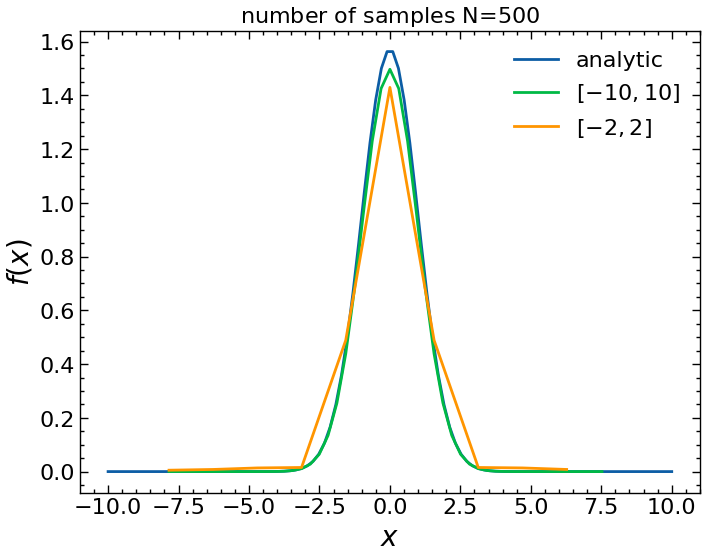

In [179]:
def gauss_mom(k, a):
    return np.sqrt(a/(2*np.pi))*np.exp(-(a*k**2)/2)

def gauss_pos(x, a):
    return (1/2*np.pi)*np.exp(-x**2/(2*a))

Nx, a = 100, 1
Nk = 500
k1, k2 = np.linspace(-10, 10, Nk), np.linspace(-2, 2, Nk)
x = np.linspace(-10, 10, Nx)
fk1, fk2 = gauss_mom(k1, a), gauss_mom(k2, a)
fx = gauss_pos(x, a)

xnew1, xnew2 = (fftfreq(len(k1), np.diff(k1)[0]/(2*np.pi))), (fftfreq(len(k2), np.diff(k2)[0]/(2*np.pi))) #We set \Delta t as \Delta \tau/2\pi
fk_FFT1, fk_FFT2 = (30/Nk)*fft(fk1), (6/Nk)*fft(fk2)

plt.plot(x, fx, label='analytic')
plt.plot(fftshift(xnew1)[225:275], np.abs(fftshift(fk_FFT1))[225:275], label='$[-10,10]$')
plt.plot(fftshift(xnew2)[245:255], np.abs(fftshift(fk_FFT2))[245:255], label='$[-2,2]$')
plt.legend(loc='best')
plt.ylabel('$f(x)$', fontsize=20)
plt.xlabel('$x$', fontsize=20)
plt.title('number of samples N=$500$')
plt.show()

Even though the sampling rate between the two domains are the same, the $[-2,2]$ plot looks more jagged than the $[-10,10]$ plot. If you cut your rectangular window too short, **spurious fourier components leak into the lower frequencies**. So we generally want to **extend our rectangular window domain as much as possible** when doing the FFT.

In [ ]:
N = 128
x = ifftshift(arange(-5,5,5./N))

y = exp(-x*x)
y_fft = fft(y) / sqrt(2 * N)

plot(fftshift(y))
plot(fftshift(y_fft))

show()